In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
from collections import defaultdict
import importlib
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
import os
from scipy.stats import linregress

# Load observations

In [2]:
# Load datasets for observations
def load_observations(file_path,sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location,max_observed_buds):
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df = pd.read_excel(xls, sheet_name = sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column = [pd.to_datetime(col).dayofyear for col in raw_df.columns if utils.is_date_column(col)]
    df = raw_df.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df.columns if utils.is_date_column(col)})

    # Apply filtering for the given cultivar & treatments
    filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]

    # Rename columns
    columns_to_select = [treatment_col] + doy_column  # Ensure it's a flat list
    filtered_df = filtered_df[columns_to_select]
    filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
    # Add the LOCATION column to the DataFrame
    filtered_df[LOCATION] = location

    # Remove rows with any NaN values
    filtered_df = filtered_df.dropna()

    # Reset index 
    filtered_df.reset_index(drop=True)

    PBB, BB, BudBurstDOY = utils.BB_specifications(filtered_df[doy_column], max_observed_buds)
    return PBB, BB, BudBurstDOY
    


# WangEngel & GDH & Chill models

In [3]:
def Chill(Tc,T):
    return float(((4*T)/(Tc**2))*(Tc-T))

def Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,T):
    RelEff = 0.0
    RelEffRefTemp = 1.0
    p = 0.0

    if (T > MinTemp) and (T < MaxTemp):
        p = np.log(2.0) / np.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEff = (2 * np.pow(T - MinTemp, p) * np.pow(OptTemp - MinTemp, p) - np.pow(T - MinTemp, 2 * p)) / np.pow(OptTemp - MinTemp, 2 * p)

    if (RefTemp > MinTemp) and (RefTemp < MaxTemp):
        p = np.log(2.0) / np.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEffRefTemp = (2 * np.pow(RefTemp - MinTemp, p) * np.pow(OptTemp - MinTemp, p) - np.pow(RefTemp - MinTemp, 2 * p)) / np.pow(OptTemp - MinTemp, 2 * p)

    return float(RelEff / RelEffRefTemp)

def GDH(Tb,Tu,Tc,T):
    HU_values = np.zeros_like(T)
    mask1 = (T > Tb) & (T <= Tu)
    mask2 = (T > Tu) & (T <= Tc)

    HU_values[mask1] = 0.5 * (1 + np.cos(np.pi + np.pi * ((T[mask1] - Tb) / (Tu - Tb))))
    HU_values[mask2] =  (1 + np.cos(0.5*np.pi + 0.5*np.pi * ((T[mask2] - Tu) / (Tc - Tu))))

    return HU_values


# Chill/Heat Accumulation

In [4]:
# Chill & heat accumulation
def chill_heat_accumulation(start_doy, buds_targets, predicted_endo_release_doy, predicted_budbreak_doy, weather_since_start_doy, sheet_name, treatment_name):


    for bud_position,target in buds_targets.items():
        
        chill_requirement = target['chill']
        heat_requirement = target['heat']
        
        # Chill model parameter
        Tc = 18
        chillVal = 0
        for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
            chillVal += Chill(Tc, temp)
            if chillVal >= chill_requirement:
                predicted_endo_release_doy[sheet_name+treatment_name][bud_position] = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release])+start_doy  # Get the date at this index
                break
        
        # from the date of endodormancy release, start accumulating heat
        heatVal = 0
        # wangengel model parameters
        MinTemp = 7
        OptTemp = 20
        MaxTemp = 25
        RefTemp = OptTemp # RefTemp = OptTemp scales the function to 0-1
        for idx_bb, temp in enumerate(weather_since_start_doy['temp'].loc[idx_endodormancy_release::]):
            heatVal += Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,temp)
            if heatVal >= heat_requirement:
                predicted_budbreak_doy[sheet_name+treatment_name][bud_position] = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release+idx_bb])+start_doy  # Get the date at this index
                break
    return predicted_endo_release_doy, predicted_budbreak_doy


In [15]:
with open("config_MultiDataFiles.json", "r") as file:
    config = json.load(file)

start_doy = pd.to_datetime('2016-03-01').dayofyear # 1st of March to start accumulation of chill units
chill_requirement_fixed = 900
heat_requirement_fixed = 500
buds_targets = {1:{'chill':chill_requirement_fixed, 'heat':heat_requirement_fixed}}#, 2:{'chill':chill_requirement_fixed, 'heat':200}, 3:{'chill':chill_requirement_fixed, 'heat':300}, 4:{'chill':chill_requirement_fixed, 'heat':400}, 5:{'chill':chill_requirement_fixed, 'heat':500}, 6:{'chill':chill_requirement_fixed, 'heat':600}}


predicted_endo_release_doy = defaultdict(lambda: dict())
predicted_budbreak_doy = defaultdict(lambda: dict())
observed_budbreak_doy = defaultdict(lambda: dict())

# Load environment variables
load_dotenv()
FOLDER_PATH = os.getenv('FOLDER_PATH')
for file_name, file_info in config.items():
        file_path = os.path.join(FOLDER_PATH, file_name)
        # Process each sheet
        for sheet_info in file_info['sheets']:
            # Extract sheet names, cultivars, and treatments
            sheet_name = sheet_info['sheet_name']
            location = sheet_info['location'].replace(' ','')
            max_observed_buds = sheet_info['max_observed_buds']
            cultivar_col, cultivar_name = list(sheet_info['cultivar'].items())[0]
            treatment_col, treatment_name = list(sheet_info['treatments'].items())[0]
            # Load the "Hourly" weather data
            weather_path = sheet_info['weather_path']
            weather_data = pd.read_csv(weather_path)
            weather_data = weather_data[['Date', 'Time', 'Air Temp. (°C)']].rename(columns={'Date': 'date', 'Time':'Time', 'Air Temp. (°C)':'temp'}, inplace=False)
            weather_data.insert(1, 'doy', [d.dayofyear for d in pd.to_datetime(weather_data['date'], format="mixed")])
            # Interpolate missing values
            # Convert '-' to NaN
            weather_data['temp'].replace('-', np.nan, inplace=True)
            weather_data['temp']=weather_data['temp'].apply(pd.to_numeric, errors='coerce')

            # Interpolate missing values
            weather_data['temp'].interpolate(method='linear', inplace=True)

            # start from the start_doy to accumulate chill/heat units
            weather_since_start_doy = weather_data[weather_data['doy']>start_doy]
            # print(weather_since_start_doy.head(30))

            # Predict the endodormancy release doy and budbreak doy
            predicted_endo_release_doy, predicted_budbreak_doy = chill_heat_accumulation(start_doy,buds_targets, predicted_endo_release_doy, predicted_budbreak_doy, weather_since_start_doy, sheet_name, treatment_name)

            # Load and calculate the observed budburst doy
            _, _, BudBurstDOY = load_observations(file_path,sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location,max_observed_buds)
            observed_budbreak_doy[sheet_name+treatment_name][1] = BudBurstDOY
            

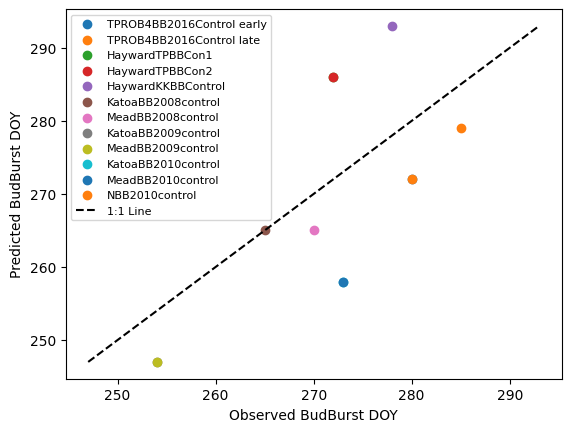

In [16]:
plt.figure()
all_bb_days = []
observed_all = []
predicted_all = []
# colors = ['k','orange','c','g','b','r','m','grey','salmon']
for (trtmnt1,bb1),(trtmnt2,bb2) in zip(predicted_budbreak_doy.items(), observed_budbreak_doy.items()):
    predicted_bb = list(bb1.values())[0]
    observed_bb = list(bb2.values())[0]
    all_bb_days.append(observed_bb)
    all_bb_days.append(predicted_bb)
    observed_all.append(observed_bb)
    predicted_all.append(predicted_bb)
    plt.scatter(observed_bb,predicted_bb, label=trtmnt2)

# Convert to numpy arrays
observed_all = np.array(observed_all)
predicted_all = np.array(predicted_all)
# Fit linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_all, predicted_all)
regression_line = slope * observed_all + intercept
# Calculate R²
r_squared = r_value ** 2
# Plot regression line
# plt.plot(observed_all, regression_line, 'k-', label=f"Regression (y={slope:.2f}x + {intercept:.2f}), R2={round(r_squared,2)}")


# Add 1:1 dashed line
plt.plot([min(all_bb_days), max(all_bb_days)], [min(all_bb_days), max(all_bb_days)], 'k--', label="1:1 Line")  # Dashed black line

plt.xlabel('Observed BudBurst DOY')
plt.ylabel('Predicted BudBurst DOY')
# plt.xlim(250,285)
# plt.ylim(250,285)
plt.legend(fontsize=8)
plt.show()

In [17]:
predicted_budbreak_doy

defaultdict(<function __main__.<lambda>()>,
            {'TPROB4BB2016Control early': {1: 272},
             'TPROB4BB2016Control late': {1: 272},
             'HaywardTPBBCon1': {1: 286},
             'HaywardTPBBCon2': {1: 286},
             'HaywardKKBBControl': {1: 293},
             'KatoaBB2008control': {1: 265},
             'MeadBB2008control': {1: 265},
             'KatoaBB2009control': {1: 247},
             'MeadBB2009control': {1: 247},
             'KatoaBB2010control': {1: 258},
             'MeadBB2010control': {1: 258},
             'NBB2010control': {1: 279}})

In [18]:
observed_budbreak_doy

defaultdict(<function __main__.<lambda>()>,
            {'TPROB4BB2016Control early': {1: 280},
             'TPROB4BB2016Control late': {1: 280},
             'HaywardTPBBCon1': {1: 272},
             'HaywardTPBBCon2': {1: 272},
             'HaywardKKBBControl': {1: 278},
             'KatoaBB2008control': {1: 265},
             'MeadBB2008control': {1: 270},
             'KatoaBB2009control': {1: 254},
             'MeadBB2009control': {1: 254},
             'KatoaBB2010control': {1: 273},
             'MeadBB2010control': {1: 273},
             'NBB2010control': {1: 285}})